In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Circle
from mpl_toolkits.mplot3d import Axes3D


In [49]:
def calculate_curve_length(points):
    """Calculate the total length of a curve defined by points"""
    diff = np.diff(points, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    return np.sum(segment_lengths)

def resample_equidistant_points(points, num_points):
    """
    Resample points along a curve to be equidistant.
    
    Args:
        points: Original points along curve (N x 2 or N x 3 array)
        num_points: Number of equidistant points to generate
        
    Returns:
        Array of equidistant points along the curve
    """
    # Calculate cumulative distances along the curve
    diff = np.diff(points, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    cumulative_lengths = np.concatenate(([0], np.cumsum(segment_lengths)))
    total_length = cumulative_lengths[-1]
    
    print("TOTAL LENGTH:", total_length)
    
    # Create interpolation for each dimension
    splines = [
        CubicSpline(cumulative_lengths, points[:, i])
        for i in range(points.shape[1])
    ]
    
    # Generate equidistant points
    desired_distances = np.linspace(0, total_length, num_points)
    resampled_points = np.zeros((num_points, points.shape[1]))
    
    for i in range(points.shape[1]):
        resampled_points[:, i] = splines[i](desired_distances)
    
    return resampled_points

def normalize_angle(angle):
    """Normalize angle to [-pi, pi]"""
    return np.arctan2(np.sin(angle), np.cos(angle))

def normalize_angles(angles):
    """Normalize an array of angles to [-pi, pi]"""
    return np.array([normalize_angle(a) for a in angles])

def calculate_total_length(positions):
    """Calculate total length of the curve from discrete points"""
    diff = np.diff(positions, axis=0)
    segment_lengths = np.sqrt(np.sum(diff * diff, axis=1))
    return np.sum(segment_lengths)

def scale_to_length(positions, target_length):
    """Scale the points to achieve a specific total length"""
    current_length = calculate_total_length(positions)
    scale_factor = target_length / current_length
    
    # Scale points around their centroid
    centroid = np.mean(positions, axis=0)
    scaled_positions = centroid + (positions - centroid) * scale_factor
    
    return scaled_positions

def calculate_yaw_from_tangent(tangent):
    """Calculate yaw angle from tangent vector, handling edge cases"""
    return np.arctan2(tangent[1], tangent[0])

def line_segment_distance(p1, p2, p3, p4):
    """
    Calculate the minimum distance between two line segments.
    p1, p2 define the first line segment
    p3, p4 define the second line segment
    """
    def dot(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def distance_point_to_segment(p, s1, s2):
        segment = s2 - s1
        length_sq = dot(segment, segment)
        if length_sq == 0:
            return np.linalg.norm(p - s1)
        t = max(0, min(1, dot(p - s1, segment) / length_sq))
        projection = s1 + t * segment
        return np.linalg.norm(p - projection)
    
    # Convert to numpy arrays for easier calculation
    p1 = np.array(p1[:2])  # Use only x,y coordinates
    p2 = np.array(p2[:2])
    p3 = np.array(p3[:2])
    p4 = np.array(p4[:2])
    
    # Calculate distances from each endpoint to the other segment
    d1 = distance_point_to_segment(p1, p3, p4)
    d2 = distance_point_to_segment(p2, p3, p4)
    d3 = distance_point_to_segment(p3, p1, p2)
    d4 = distance_point_to_segment(p4, p1, p2)
    
    return min(d1, d2, d3, d4)

def check_self_collision(positions, min_distance):
    """
    Check if any segments of the rope are too close to each other.
    Returns True if there is a collision, False otherwise.
    """
    n_segments = len(positions)
    
    # Check each pair of non-adjacent segments
    for i in range(n_segments - 2):
        for j in range(i + 2, n_segments-1):
            # Skip adjacent segments
            if abs(i - j) <= 1:
                continue
            
            # Calculate distance between segments
            dist = line_segment_distance(
                positions[i], positions[i+1],
                positions[j], positions[j+1]
            )
            
            # Check if distance is less than minimum allowed
            if dist < min_distance:
                return True
    return False

def compute_relative_quaternions(positions):
    """
    Compute relative quaternions between adjacent segments based on the direction to next point.
    Returns quaternions that represent the relative rotation from segment i to segment i+1.
    """
    num_segments = len(positions)
    relative_quaternions = np.zeros((num_segments, 4))  # (w, x, y, z) format
    
    # First find all direction vectors between consecutive points
    # Ensure positions is a numpy array
    positions = np.array(positions)
    
    # Calculate directions only for x,y components
    directions = np.zeros((num_segments, 2))
    directions[:-1] = positions[1:, :2] - positions[:-1, :2]  # Only use x,y coordinates
    directions[-1] = directions[-2]  # Last direction same as second-to-last
    
    # Normalize directions
    norms = np.sqrt(np.sum(directions * directions, axis=1))
    norms[norms == 0] = 1  # Avoid division by zero
    directions = directions / norms[:, np.newaxis]
    
    # Calculate yaw angles from directions
    absolute_yaws = np.arctan2(directions[:, 1], directions[:, 0])
    
    # First quaternion represents rotation from world frame to first direction
    first_rotation = Rotation.from_euler('z', absolute_yaws[0])
    quat = first_rotation.as_quat()  # (x, y, z, w) format
    relative_quaternions[0] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    # For remaining points, calculate relative rotation from previous direction to current
    for i in range(1, num_segments):
        # Calculate relative yaw (difference between consecutive absolute yaws)
        delta_yaw = normalize_angle(absolute_yaws[i] - absolute_yaws[i-1])
        
        # Convert to quaternion (rotation around Z axis)
        rotation = Rotation.from_euler('z', delta_yaw)
        quat = rotation.as_quat()  # (x, y, z, w) format
        relative_quaternions[i] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    return relative_quaternions

def generate_2d_rope_configuration(
    num_segments=28,
    workspace_bounds=np.array([[-0.5, 0.5], [-0.5, 0.5]]),
    num_control_points=5,
    z_height=0.1,
    noise_scale=0.02,
    max_delta_yaw=np.pi/4,
    min_segment_distance=0.05,
    max_attempts=100,
    curve_resolution=200,
    total_length=0.3
):
    """Generate random rope configuration with corrected orientations."""
    
    def smooth_angles(angles, max_delta):
        """Apply iterative smoothing to ensure max angle delta is respected"""
        smoothed = angles.copy()
        while True:
            original = smoothed.copy()
            
            # Forward pass
            for i in range(1, len(smoothed)):
                # Calculate delta in a way that respects angle wrapping
                delta = normalize_angle(smoothed[i] - smoothed[i-1])
                if abs(delta) > max_delta:
                    smoothed[i] = normalize_angle(smoothed[i-1] + np.sign(delta) * max_delta)
            
            # Backward pass
            for i in range(len(smoothed)-2, -1, -1):
                delta = normalize_angle(smoothed[i] - smoothed[i+1])
                if abs(delta) > max_delta:
                    smoothed[i] = normalize_angle(smoothed[i+1] + np.sign(delta) * max_delta)
            
            if np.allclose(original, smoothed, atol=1e-6):
                break
                
        return smoothed

    for attempt in range(max_attempts):
        # Generate random control points with increasing spread
        control_points = np.zeros((num_control_points, 2))
        spread_scale = np.linspace(0.3, 1.0, num_control_points)
        
        for i in range(2):
            bounds_range = workspace_bounds[i, 1] - workspace_bounds[i, 0]
            control_points[:, i] = workspace_bounds[i, 0] + bounds_range * (
                0.5 + spread_scale * np.random.uniform(-0.5, 0.5, num_control_points)
            )
        
        # Generate initial curve with high resolution
        t_dense = np.linspace(0, 1, curve_resolution)
        splines = [
            CubicSpline(np.linspace(0, 1, num_control_points), control_points[:, i])
            for i in range(2)
        ]
        
        # Sample dense points along the curve
        dense_points = np.zeros((curve_resolution, 2))
        for i in range(2):
            dense_points[:, i] = splines[i](t_dense)
            
        dense_points = scale_to_length(dense_points, total_length)
        
        # Resample to get equidistant points
        positions_2d = resample_equidistant_points(dense_points, num_segments)
        
        # Add Z coordinate
        positions = np.zeros((num_segments, 3))
        positions[:, :2] = positions_2d
        positions[:, 2] = z_height
        
        # Calculate tangent vectors using finite differences
        tangents = np.zeros((num_segments, 2))
        tangents[:-1] = np.diff(positions_2d, axis=0)
        tangents[-1] = tangents[-2]  # Use last valid tangent for final point
        
        # Normalize tangents
        norms = np.sqrt(np.sum(tangents * tangents, axis=1))
        tangents = tangents / norms[:, np.newaxis]
        
        # Calculate yaw angles from tangents with proper normalization
        yaw_angles = np.array([calculate_yaw_from_tangent(t) for t in tangents])
        yaw_angles = normalize_angles(yaw_angles)
        
        # Smooth the angles to satisfy max_delta constraint
        smoothed_yaws = smooth_angles(yaw_angles, max_delta_yaw)
        
        # Check constraints
        if not check_self_collision(positions, min_segment_distance):
            # Compute relative quaternions based on positions
            relative_quaternions = compute_relative_quaternions(positions)
            
            # Verify the relative rotations
            relative_yaws = np.array([
                2 * np.arccos(np.clip(quat[0], -1, 1)) for quat in relative_quaternions
            ])
            
            if np.all(relative_yaws <= max_delta_yaw + 1e-6):
                segment_distances = np.sqrt(np.sum(np.diff(positions, axis=0)**2, axis=1))
                total_length_achieved = np.sum(segment_distances)
                
                # Compute cumulative yaw for verification
                cumulative_yaw = np.zeros(num_segments)
                for i in range(1, num_segments):
                    w, x, y, z = relative_quaternions[i]
                    relative_yaw = 2 * np.arctan2(z, w)
                    cumulative_yaw[i] = cumulative_yaw[i-1] + relative_yaw
                
                return positions, relative_quaternions, smoothed_yaws
            
    raise ValueError(f"Failed to generate valid configuration after {max_attempts} attempts")


In [50]:
%matplotlib widget
def compute_absolute_quaternions(relative_quaternions):
    """
    Convert relative quaternions to absolute quaternions by accumulating rotations.
    """
    num_segments = len(relative_quaternions)
    absolute_quaternions = np.zeros_like(relative_quaternions)
    absolute_quaternions[0] = relative_quaternions[0]  # First quaternion is already in world frame
    
    # Accumulate rotations
    current_rotation = Rotation.from_quat([
        relative_quaternions[0, 1],  # x
        relative_quaternions[0, 2],  # y
        relative_quaternions[0, 3],  # z
        relative_quaternions[0, 0]   # w
    ])
    
    for i in range(1, num_segments):
        # Get the relative rotation for this segment
        relative_rotation = Rotation.from_quat([
            relative_quaternions[i, 1],  # x
            relative_quaternions[i, 2],  # y
            relative_quaternions[i, 3],  # z
            relative_quaternions[i, 0]   # w
        ])
        
        # Compose with previous rotation
        current_rotation = current_rotation * relative_rotation
        
        # Convert back to quaternion and store
        quat = current_rotation.as_quat()  # Returns (x, y, z, w)
        absolute_quaternions[i] = np.array([quat[3], quat[0], quat[1], quat[2]])  # Convert to (w, x, y, z)
    
    return absolute_quaternions

def visualize_rope_configuration(positions, relative_quaternions, segment_length=0.05, min_segment_distance=0.05):
    """
    Visualize rope configuration with corrected orientation arrows, using relative quaternions.
    """
    # Convert relative quaternions to absolute for visualization
    absolute_quaternions = compute_absolute_quaternions(relative_quaternions)
    
    fig = plt.figure(figsize=(15, 6))
    
    # Create subplots: top view (2D) and perspective view (3D)
    ax1 = fig.add_subplot(121)  # 2D view
    ax2 = fig.add_subplot(122, projection='3d')  # 3D view
    
    # Plot 2D view (top-down)
    ax1.set_title('Top View (X-Y Plane)')
    
    # Plot positions and connection lines
    ax1.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.5, label='Rope Path')
    ax1.scatter(positions[:, 0], positions[:, 1], c='blue', s=30)
    
    # Plot orientation arrows
    for i, (pos, quat) in enumerate(zip(positions, absolute_quaternions)):
        # Convert quaternion to rotation matrix using scipy
        rotation = Rotation.from_quat([quat[1], quat[2], quat[3], quat[0]])  # Convert to scipy's format
        # Get the x-axis direction after rotation
        direction = rotation.apply([1, 0, 0])[:2]  # Take only x,y components
        
        # Create arrow for orientation
        ax1.arrow(
            pos[0], pos[1],
            direction[0] * segment_length,
            direction[1] * segment_length,
            head_width=0.02,
            head_length=0.02,
            fc='red',
            ec='red'
        )
        
        # Draw collision boundary circle
        if i % 3 == 0:  # Draw every third circle to avoid clutter
            circle = Circle(
                (pos[0], pos[1]),
                min_segment_distance/2,
                fill=False,
                linestyle='--',
                color='gray',
                alpha=0.3
            )
            ax1.add_patch(circle)
    
    # Set equal aspect ratio and grid
    ax1.set_aspect('equal')
    ax1.grid(True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # Plot 3D view
    ax2.set_title('Perspective View')
    
    # Plot positions and connection lines
    ax2.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', alpha=0.5)
    ax2.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=30)
    
    # Plot orientation arrows in 3D
    for pos, quat in zip(positions, absolute_quaternions):
        rotation = Rotation.from_quat([quat[1], quat[2], quat[3], quat[0]])
        direction = rotation.apply([1, 0, 0])
        
        ax2.quiver(
            pos[0], pos[1], pos[2],
            direction[0] * segment_length,
            direction[1] * segment_length,
            direction[2] * segment_length,
            color='red',
            alpha=0.6
        )
    
    # # Add visualization of relative rotations
    # ax3 = fig.add_subplot(223)
    # ax3.set_title('Relative Yaw Angles')
    
    # # Extract relative yaw angles
    # relative_yaws = np.array([
    #     2 * np.arctan2(quat[3], quat[0])  # z and w components for yaw
    #     for quat in relative_quaternions
    # ])
    
    # ax3.plot(relative_yaws * 180/np.pi, 'g-', label='Relative Yaw')
    # ax3.set_xlabel('Segment Index')
    # ax3.set_ylabel('Relative Yaw (degrees)')
    # ax3.grid(True)
    # ax3.legend()
    
    plt.tight_layout()
    plt.show()

TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.2896551799999996
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.28965517999999946
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.2896551799999995
TOTAL LENGTH: 0.28965518
TOTAL LENGTH: 0.28965518000000023
TOTAL LENGTH: 0.2896551800000001
TOTAL LENGTH: 0.28965517999999973
TOTAL LENGTH: 0.28965518000000057
TOTAL LENGTH: 0.28965517999999996
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.28965517999999996
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000004
TOTAL LENGTH: 0.2896551800000001
TOTAL LENGTH: 0.2896551800000012
TOTAL LENGTH: 0.28965518
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH: 0.2896551800000005
TOTAL LENGTH: 0.28965518000000035
TOTAL LENGTH: 0.2896551800000007
TOTAL LENGTH: 0.2896551799999999
TOTAL LENGTH: 0.2896551799999997
TOTAL LENGTH: 0.28965518000000073
TOTAL LENGTH: 0.2896551799999999
TOTAL LENGTH: 0.28965518000000007
TOTAL LENGTH: 0.28965517999999985
TOTAL LENGTH:

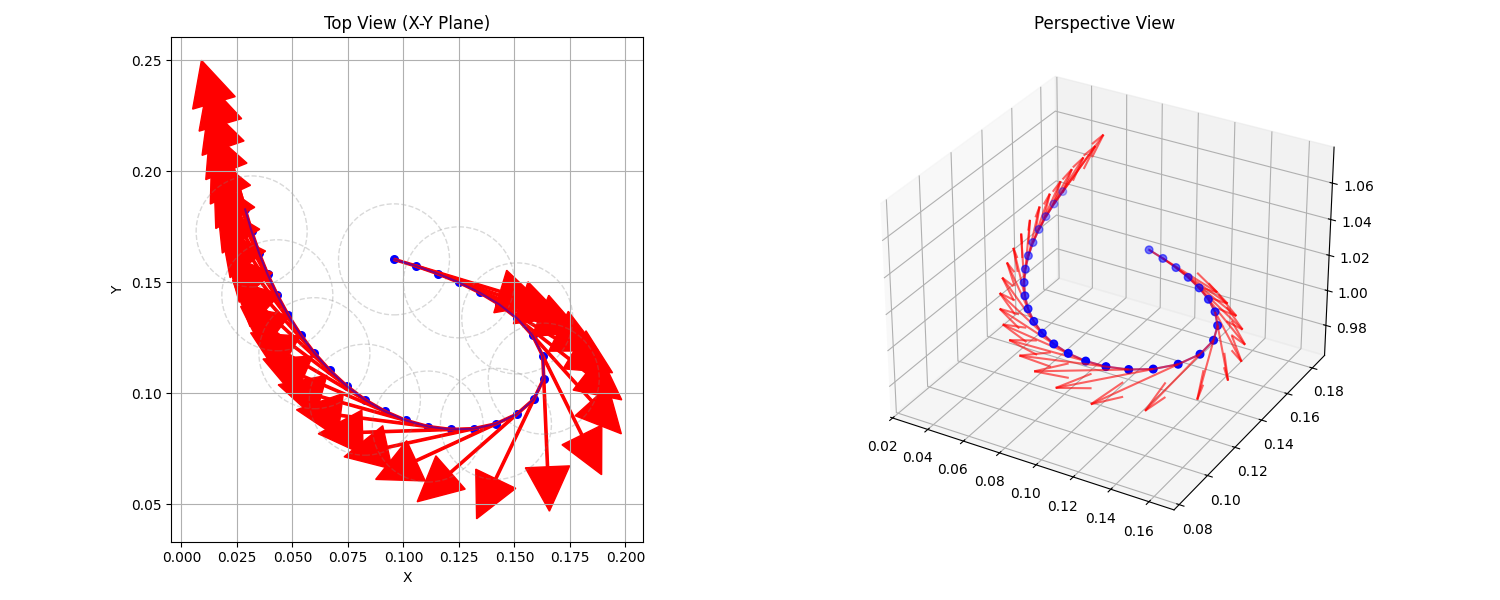

Configuration Statistics:
Z-height mean: 1.021000
Z-height std: 0.000000
Number of segments: 29

Quaternion Statistics:
Mean absolute X component: 0.0
Mean absolute Y component: 0.0


In [51]:
# Generate a sample configuration
positions, quaternions, yaw_angles = generate_2d_rope_configuration(
    num_segments=29,
    workspace_bounds=np.array([(0.011, 0.24), (0.007, 0.27)]),
    z_height=1.021,
    num_control_points=4,
    max_delta_yaw=np.pi/6,
    min_segment_distance=0.01,
    max_attempts=1000,
    curve_resolution=2000,
    total_length=0.28965518
)

# Visualize it
visualize_rope_configuration(positions, quaternions)

# Print some statistics
print("Configuration Statistics:")
print(f"Z-height mean: {positions[:, 2].mean():.6f}")
print(f"Z-height std: {positions[:, 2].std():.6f}")
print(f"Number of segments: {len(positions)}")

# Verify quaternions are yaw-only (x and y component
# s should be ~0)
print("\nQuaternion Statistics:")
print("Mean absolute X component:", np.abs(quaternions[:, 1]).mean())
print("Mean absolute Y component:", np.abs(quaternions[:, 2]).mean())

In [52]:
for i in range(len(positions) - 1):
    a = positions[i]
    b = positions[i + 1]
    print(f"Distance between {i} and {i + 1}: {np.linalg.norm(a - b):.6f}")

Distance between 0 and 1: 0.010344
Distance between 1 and 2: 0.010344
Distance between 2 and 3: 0.010343
Distance between 3 and 4: 0.010342
Distance between 4 and 5: 0.010341
Distance between 5 and 6: 0.010336
Distance between 6 and 7: 0.010325
Distance between 7 and 8: 0.010294
Distance between 8 and 9: 0.010244
Distance between 9 and 10: 0.010251
Distance between 10 and 11: 0.010295
Distance between 11 and 12: 0.010319
Distance between 12 and 13: 0.010328
Distance between 13 and 14: 0.010333
Distance between 14 and 15: 0.010335
Distance between 15 and 16: 0.010336
Distance between 16 and 17: 0.010338
Distance between 17 and 18: 0.010339
Distance between 18 and 19: 0.010340
Distance between 19 and 20: 0.010341
Distance between 20 and 21: 0.010341
Distance between 21 and 22: 0.010342
Distance between 22 and 23: 0.010343
Distance between 23 and 24: 0.010343
Distance between 24 and 25: 0.010343
Distance between 25 and 26: 0.010344
Distance between 26 and 27: 0.010344
Distance between 27 

In [9]:
import numpy as np
import cv2
import time

# Create sample masks (1920x1080)
mask1 = np.random.randint(0, 2, (1080, 1920, 3), dtype=np.uint8)
mask2 = np.random.randint(0, 2, (1080, 1920), dtype=np.uint8)

# Test multiplication
# start = time.time()
# for _ in range(1000):
#     result = mask1 * mask2
# print(f"Multiplication: {time.time() - start:.4f}s")

# Test cv2.bitwise_and
start = time.time()
for _ in range(1000):
    result = cv2.bitwise_and(mask1, mask1, mask = mask2)
print(f"OpenCV bitwise_and: {time.time() - start:.4f}s")

# Test logical_and
start = time.time()
for _ in range(1000):
    result = np.logical_and(mask1, np.expand_dims(mask2, -1))
print(f"Logical AND: {time.time() - start:.4f}s")


OpenCV bitwise_and: 0.9169s
Logical AND: 8.1462s
